In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.SeqUtils import seq1 as seq3to1
from Bio.PDB import PDBParser, PDBIO

In [2]:
FIGURES_OUTPUT_PATH = "figures"
os.system(f"mkdir -p {FIGURES_OUTPUT_PATH}");

GLP1_GLP1R_COMPLEX_PDB_FILE = "../data/glp1/6x18_glp1-7-36_glp1r-full_nowater_nocap.pdb"
GLP1_RESIDUE_OFFSET = 7

MATCHED_PDB_PATH = "../glp1-matcher/outputs/matches"
SCORED_PDB_PATH = "../glp1-matcher/outputs/scores/pdbs"
SCAN_STATISTICS_FILE = "../glp1-matcher/outputs/scores/scan_statistics.csv"

IFACE_SCORE_CUTOFF = 0.0
CST_SCORE_CUTOFF = 20
PERCENTILE_CUTOFF = 25
N_CONFORMERS_CUTOFF = 1
N_SAMPLES = 10

## Parse the scan statistics csv file

In [3]:
df = pd.read_csv(SCAN_STATISTICS_FILE)
display(df)

,position,cluster,cst_score,iface_score
0,30,690,6.225,-181.133
1,26,505,10.931,-176.371
2,31,3362,4.831,-177.052
3,29,4775,5.619,-183.812
4,33,3045,6.056,-157.113
...,...,...,...,...
15611,27,27,3.663,-182.009
15612,23,706,5.570,-169.720
15613,30,8968,20.224,-191.252
15614,26,262,4.035,-151.247


## Make scatter plot of GLP1-GLP1R interface energy and constraint score

Filter the data according to cutoffs on peptide-protein interface score and match-score. Then select ones in the top percentile of both the scores.

In [4]:
# filter the dataframe with the given cutoffs
filtered_df = df[
        (df["cst_score"] < CST_SCORE_CUTOFF) & \
        (df["iface_score"] < IFACE_SCORE_CUTOFF)
]


X_field = "iface_score"
Y_field = "cst_score"

# get percentile cutoff
X_bound = np.percentile(filtered_df[X_field].values, q=PERCENTILE_CUTOFF)
Y_bound = np.percentile(filtered_df[Y_field].values, q=PERCENTILE_CUTOFF)

# assign a select_yn decision based on these percentiles
select = []
for (X, Y) in zip(filtered_df[X_field].values, filtered_df[Y_field].values):
    decision = int((X <= X_bound and Y <= Y_bound))
    select.append(decision)
filtered_df = filtered_df.assign(select=select)

Plot the score landscape from Matcher

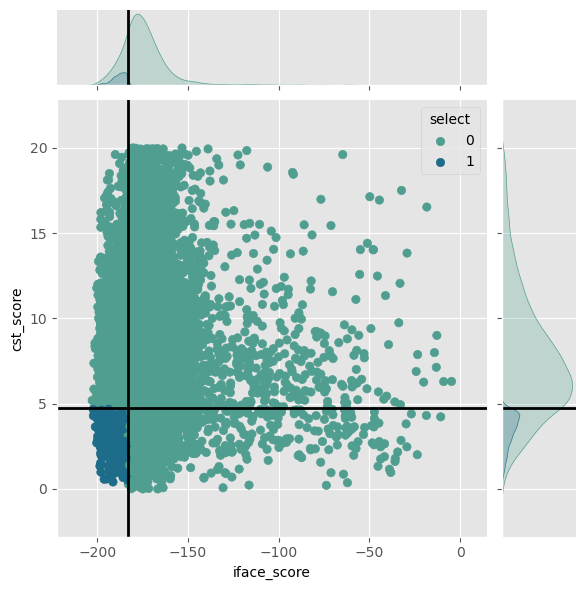

In [5]:
plt.style.use("ggplot")
jg = sns.jointplot(
    data=filtered_df,
    x=X_field, y=Y_field, hue="select",
    kind="scatter", edgecolor=None, palette="crest"
)
    
for ax in [jg.ax_joint, jg.ax_marg_x]:
    ax.axvline(x=X_bound, color="black", lw=2)

for ax in [jg.ax_joint, jg.ax_marg_y]:
    ax.axhline(y=Y_bound, color="black", lw=2)
    
plt.show()
figname = os.path.join(FIGURES_OUTPUT_PATH, "glp1_matcher_score_landscape.png")
jg.figure.savefig(figname, bbox_inches="tight", dpi=200)

## Select a residue if it has at least `N_CONFORMERS_CUTOFF` conformations in this region
#### (bottom left quadrant in abvove figure)

In [6]:
# get residues
model = PDBParser(QUIET=True).get_structure("x", GLP1_GLP1R_COMPLEX_PDB_FILE)[0]
residues = sorted([r for r in model["P"].get_residues() if r.id[0] == " "], key=lambda r: r.id[1])

# at least one classification
res_map = {r.id[1]: r for r in residues}
sel_map = {r.id[1]: 0 for r in residues}

for i in range(len(filtered_df)):
    pos = filtered_df.iloc[i]["position"]
    sel_map[pos] += int(filtered_df.iloc[i]["select"])

# assign decision to acylate or not to residues, based on probabilities
df_select = []
for resid in sorted(sel_map):
    resname = seq3to1(res_map[resid].resname.upper())
    this_select = int(sel_map[resid] >= N_CONFORMERS_CUTOFF)
    if this_select:
        df_select.append((resid, resname, sel_map[resid]))
    
df_select = pd.DataFrame(df_select, columns=["resid", "aa", "n_matches"])
display(df_select)

,resid,aa,n_matches
0,15,D,1
1,18,S,4
2,19,Y,7
3,20,L,1
4,22,G,37
5,23,Q,65
6,26,K,52
7,27,E,13
8,29,I,61
9,30,A,269


Protractable sites found in the [semaglutide paper](https://pubs.acs.org/doi/full/10.1021/acs.jmedchem.5b00726) using only gGLU-2xOEG-C18 diacid protractor were: 16, 22, 25, 26, 27. Out of these only 25 has been filtered out by our rosetta-matcher protocol. 

## Get conformation clusters for valid sites

For a given site, we'll pick a `<N_SAMPLES>` random conformations (each corresponding to the cluster centroid of a matcher solution ensemble) to be used as inputs for downstream MD pipelines.

In [12]:
cluster_ids = []
for i in range(len(df_select)):
    resid = df_select.iloc[i]["resid"]
    this_df = filtered_df[filtered_df["position"] == resid]
    this_df_samples = this_df.sample(n=min(N_SAMPLES, len(this_df)))
    this_cluster_ids = list(this_df_samples["cluster"].values)
    cluster_ids.append(this_cluster_ids)
df_select = df_select.assign(cluster_ids=cluster_ids)
display(df_select)

,resid,aa,n_matches,cluster_ids
0,14,S,8,"[178, 154, 114, 111, 195, 103, 215, 201, 116, ..."
1,15,D,48,"[241, 259, 145, 180, 108, 77, 142, 254, 106, 390]"
2,16,V,2,"[769, 744, 536, 636, 724, 568, 515, 601, 745, ..."
3,18,S,81,"[396, 352, 624, 354, 353, 546, 594, 494, 510, ..."
4,19,Y,47,"[339, 54, 62, 1204, 63, 461, 1200, 354, 1232, ..."
5,20,L,15,"[945, 668, 694, 757, 1213, 1206, 703, 520, 829..."
6,22,G,113,"[581, 331, 709, 527, 258, 793, 825, 450, 742, ..."
7,23,Q,100,"[218, 1084, 736, 163, 422, 309, 9, 618, 721, 610]"
8,26,K,74,"[401, 248, 370, 894, 758, 108, 513, 766, 222, ..."
9,27,E,27,"[591, 106, 63, 237, 751, 132, 256, 632, 603, 298]"


The pdb files corresponding to these `cluster_ids` can be selected from `SCORED_PDB_PATH`.

In [16]:
def get_pdbs(resid, cluster_ids):
    match_res_name = "K"
    pdbs = []
    for c in cluster_ids:
        glob_str = os.path.join(SCORED_PDB_PATH, f"UM_{c}_{match_res_name}{resid}_*_1_0001.pdb")
        this_pdb = glob.glob(glob_str)
        assert len(this_pdb) == 1
        this_pdb = this_pdb[0]
        pdbs.append(this_pdb)
    return pdbs

In [17]:
for i in range(len(df_select)):
    this_df = df_select.iloc[i]
    resid = this_df["resid"]
    cluster_ids = this_df["cluster_ids"]
    pdbs = get_pdbs(resid, cluster_ids)
    
    print("\nresid: ", resid)
    for p in pdbs:
        print(p, os.path.isfile(p))


resid:  14
../glp1-matcher/outputs/scores/pdbs/UM_178_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_154_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_114_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_111_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_195_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_103_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_215_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_201_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_116_K14_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_174_K14_glp1_glp1_1_0001.pdb True

resid:  15
../glp1-matcher/outputs/scores/pdbs/UM_241_K15_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_259_K15_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/scores/pdbs/UM_145_K15_glp1_glp1_1_0001.pdb True
../glp1-matcher/outputs/sco